Ready
['cyto3', 'nuclei', 'cyto2_cp3', 'tissuenet_cp3', 'livecell_cp3', 'yeast_PhC_cp3', 'yeast_BF_cp3', 'bact_phase_cp3', 'bact_fluor_cp3', 'deepbacs_cp3', 'cyto2', 'cyto', 'CPx', 'transformer_cp3', 'neurips_cellpose_default', 'neurips_cellpose_transformer', 'neurips_grayscale_cyto2', 'CP', 'CPx', 'TN1', 'TN2', 'TN3', 'LC1', 'LC2', 'LC3', 'LC4']
>>> GPU activated? YES
['cyto3', 'nuclei', 'cyto2_cp3', 'tissuenet_cp3', 'livecell_cp3', 'yeast_PhC_cp3', 'yeast_BF_cp3', 'bact_phase_cp3', 'bact_fluor_cp3', 'deepbacs_cp3', 'cyto2', 'cyto', 'CPx', 'CP', 'CPx', 'TN1', 'TN2', 'TN3', 'LC1', 'LC2', 'LC3', 'LC4']
cyto3


KeyboardInterrupt: 

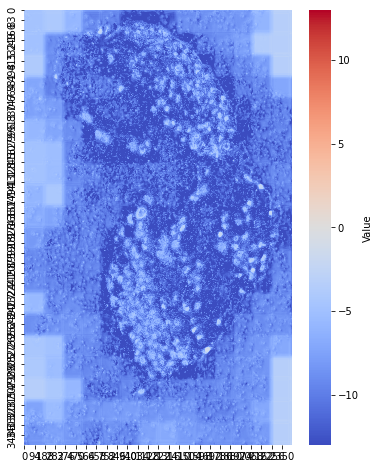

In [2]:
#Inputs: List of initial models to use, desired image folder (H&E vs UnremovedTranscripts), drg4 image path, manual drg4 path
#Outputs: Metrics csvs corresponding to each initial model
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import re
import cv2
from PIL import Image
from glob import glob
from read_roi import read_roi_file, read_roi_zip
from cellpose import core, utils, io, models, metrics, plot, train
import time
import svgwrite
import seaborn as sns
import random

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Optional: for PyTorch-based models (Cellpose may use this internally)
import torch
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

#Run Evaluation Pipeline to access the methods
%run /media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Cellpose/Finalized\ Code/Training/evaluationPipeline.ipynb

model_list = [i for i in models.MODEL_NAMES if 'transformer' not in i and 'neurips' not in i]

flow_threshold = 0.4 #@param {type:"slider", min:0.0, max:3.0, step:0.1}
cellprob_threshold = 0 #@param {type:"slider", min:-6, max:6, step:1}

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

#'H&EStain' or 'UnremovedTranscripts'
img_folder = 'UnremovedTranscripts'
    
c1 = "Red" #@param ["Grayscale", "Blue", "Green", "Red"]
c2 = "None" #@param ["None", "Blue", "Green", "Red"]

#HE image directory
he_dir = '/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Cellpose/Updated_Figures/Evaluation Image/DRG4HeImg'
#Transcript image directory
trans_dir = '/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Cellpose/Updated_Figures/Evaluation Image/TransDRG4'

if img_folder == 'H&EStain':
    eval_dir = he_dir
    pred_path = eval_dir + '/csv/drg4.csv'
    out_dir = '/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Cellpose/Updated_Figures/Default Models HE'
    man_path = '/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Xenium_segementation/ManuscriptProject/Scaled_DRG_Manual_Annotations/drg4_manual_scaled.csv'
else:
    eval_dir = trans_dir
    pred_path = eval_dir + '/csv/croppedDRG4.csv'
    out_dir = '/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Cellpose/Updated_Figures/Default Models Trans'
    man_path = '/media/yhs/5596744f-db7c-442f-9235-d0c9d50c0a6b/Cellpose/Updated_Figures/Evaluation Image/ManualDRG4/drg4manual.csv'

def save_rois_with_conversion(masks, files, output_dir):
    # Ensure all masks are in the correct format
    masks = [mask.astype(np.uint16) if mask.dtype != np.uint16 else mask for mask in masks]
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    count = 0
    for file, mask in zip(files, masks):
        count += 1
        output_path = os.path.join(output_dir, file.split('/')[-1].replace('.jpg',''))
        io.save_rois(mask, output_path)
def zip_to_csv(directory):
    for filename in [i for i in os.listdir(directory) if '.zip' in i]:
        df_data = {'Name': [], 'X': [], 'Y': []}
        file_path = os.path.join(directory, filename)
        data = read_roi_zip(file_path)
        for name, roi in data.items():
            df_data['X'].extend(roi['x'])
            df_data['Y'].extend(roi['y'])
            for i in range(len(roi['x'])):
                df_data['Name'].append(str(roi['name']))
        df = pd.DataFrame.from_dict(df_data)
        out_dir = os.path.join(directory, 'csv')
        os.makedirs(out_dir, exist_ok=True)
        df.to_csv(os.path.join(out_dir, filename).replace('.zip','.csv').replace('_rois','').replace('Nonseg','Seg'), sep=',', index=False, header=True)

for model_name in model_list:
    print(model_name)
    start_time = time.time()

    out_path = os.path.join(out_dir, model_name + '_drg4.csv')
    heatmap_out_path = os.path.join(out_dir, model_name + '_heatmap.tif')
    
    #@markdown ###Path to images:
    
    dir = eval_dir #@param {type:"string"}
    
    #@markdown ###Channel Parameters:
    
    Channel_to_use_for_segmentation = c1 #@param ["Grayscale", "Blue", "Green", "Red"]
    
    # @markdown If you have a secondary channel that can be used, for instance nuclei, choose it here:
    
    Second_segmentation_channel= c2 #@param ["None", "Blue", "Green", "Red"]
    
    
    # Here we match the channel to number
    if Channel_to_use_for_segmentation == "Grayscale":
      chan = 0
    elif Channel_to_use_for_segmentation == "Blue":
      chan = 3
    elif Channel_to_use_for_segmentation == "Green":
      chan = 2
    elif Channel_to_use_for_segmentation == "Red":
      chan = 1
    
    
    if Second_segmentation_channel == "Blue":
      chan2 = 3
    elif Second_segmentation_channel == "Green":
      chan2 = 2
    elif Second_segmentation_channel == "Red":
      chan2 = 1
    elif Second_segmentation_channel == "None":
      chan2 = 0
    
    #@markdown ### Segmentation parameters:
    
    
    # gets image files in dir (ignoring image files ending in _masks)
    files = io.get_image_files(dir, '_masks')
    images = [io.imread(f) for f in files]
    
    diameter = 0
    # declare model
    model = models.CellposeModel(gpu=use_GPU, model_type=model_name)
    
    # use model diameter if user diameter is 0
    diameter = model.diam_labels if diameter==0 else diameter
    
    # run model on test images
    masks, flows, styles = model.eval(images,
                                      channels=[chan, chan2],
                                      diameter=diameter,
                                      flow_threshold=flow_threshold,
                                      cellprob_threshold=cellprob_threshold
                                      )
    
    io.masks_flows_to_seg(images,
                          masks,
                          flows,
                          files,
                          channels=[chan, chan2],
                          diams=diameter*np.ones(len(masks)),
                          )


    # Example 2D array (replace this with your actual data)
    data = flows[0][2]

    # Get the shape of the data
    height, width = data.shape
    
    # Define a base figure size, adjusting for large dimensions
    scaling_factor = 0.0025  # Adjust this to control the overall size
    fig_width = 6 
    fig_height = 8 
    
    # Create the figure with the calculated size
    plt.figure(figsize=(fig_width, fig_height))
    
    # Create the heatmap
    sns.heatmap(data, cmap="coolwarm", annot=False, fmt=".2f", cbar_kws={'label': 'Value'}, vmin=-13, vmax=13)
    
    # Labels and title
    plt.title(model_name)
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    
    # Save as SVG
    plt.savefig(heatmap_out_path, format="tif", bbox_inches="tight", dpi=300)
    
    # Show the plot
    plt.show()
    
    save_rois_with_conversion(masks, files, eval_dir)
    
    zip_to_csv(eval_dir)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'DRG4 Eval Complete in {elapsed_time:.2f} seconds')
    
    start_time = time.time()
    
    performance = optimized_model_eval_files(man_path, pred_path)
    
    df_csv = pd.DataFrame.from_dict(performance)
    df_csv.to_csv(out_path)
    print(out_path)
    end_time = time.time()
    
    elapsed_time = end_time-start_time
    
    print(f'Eval Pipeline Complete in {elapsed_time:.2f} seconds')